In [3]:
import os
import copy
import random
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [6]:
def createpres(p, resamplelen):

  #p = signal.resample(p, (len(p))//resamplelen).tolist()
  p = p[0].values.tolist()
  return p


from google.colab import drive
drive.mount('/content/drive')

names = pd.read_csv('/content/drive/MyDrive/channels.tbl.20250225', delimiter=' ')
names = names.T.values.tolist()

pathtopressure = r'/content/drive/MyDrive/resampled/2025_18days'

presnames = names[0]

#sequence_length = 287
sequence_length = 432
resamplelen = 1
num_stations = len(names[0])

pressure_n = []
station_data = {}
pressure=[]

for i in range(num_stations):
  pressure_n = createpres(pd.read_csv(pathtopressure + presnames[i] + '.dat', delimiter='\t', header=None)[:sequence_length], resamplelen)
  pressure.append(pressure_n)
  station_data[f'station_{i}'] = pd.Series(pressure_n, index=pd.date_range("2025-02-23", periods=sequence_length, freq="h"))

fullstationdata = copy.deepcopy(station_data)
print(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0


In [7]:

start = [0, 84, 168, 252]
end   = [84, 168, 252, 336]
# worst — malfunctioning stations' id
worst = [15, 16, 37, 38, 51, 52, 72, 73, 74, 86, 87, 125, 126, 152, 153,
         179, 180, 207, 208, 215, 216, 90, 91, 23, 24, 80, 81, 203, 204]
to_remove = [80, 81, 336, 337]  # deleting first 2 periods for the station which failed during observation
test_size = 0.2
random_state = 42
metric_to_optimize = 'f1'
n_thresholds = 200
latent_dim = 32
# ----------------------------------------------


def select_grouped_stations(names, bad, K, N, seed=None):
    if seed is not None:
        random.seed(seed)

    num_stations = len(names[0])
    indices = list(range(num_stations))

    # names[3][i] - name of the i-th station (as in original)
    groups = defaultdict(list)
    for i in indices:
        key = names[3][i]
        groups[key].append(i)

    # Grouping into bad/neutral depending on whether any index in group intersects bad
    group_categories = {'bad': [], 'neutral': []}
    bad_set = set(bad)

    for group in groups.values():
        group_set = set(group)
        if group_set & bad_set:
            group_categories['bad'].append(group)
        else:
            group_categories['neutral'].append(group)

    def select_groups_with_limit(group_list, target_count, current_total, max_total):
        random.shuffle(group_list)
        selected = []
        selected_count = 0
        for group in group_list:
            group_len = len(group)
            if selected_count >= target_count:
                break
            if current_total + group_len > max_total:
                continue  # Skip the group if it does not fit in
            selected.append(group)
            selected_count += group_len
            current_total += group_len
        return selected, selected_count, current_total

    # Group selection: first pick bad groups, then neutral to fill up to N
    selected_bad, count_bad, total_count = select_groups_with_limit(group_categories['bad'], K, 0, N)

    selected_neutral, count_neutral, total_count = select_groups_with_limit(
        group_categories['neutral'], N - (count_bad), total_count, N
    )

    selected_groups = selected_bad + selected_neutral
    final_selection = [i for group in selected_groups for i in group]

    return final_selection

X_list = []
sample_station_idx = []
sample_segment_idx = []
for seg_idx, (s_idx, e_idx) in enumerate(zip(start, end)):
    for st in range(num_stations):
        arr = fullstationdata[f'station_{st}'].iloc[s_idx:e_idx].values
        X_list.append(arr)
        sample_station_idx.append(st)
        sample_segment_idx.append(seg_idx)
X = np.array(X_list)
num_samples = X.shape[0]
assert num_samples == num_stations * len(start)

bad = worst.copy()
for k in range(1, len(start)):
    bad += [x + k * num_stations for x in worst]
for r in to_remove:
    try:
        bad.remove(r)
    except ValueError:
        pass

y = np.zeros(num_samples, dtype=int)
for idx in bad:
    if 0 <= idx < num_samples:
        y[idx] = 1

print("Total y distribution:", np.bincount(y))


K = len(worst) // len(start)
N = len(names[0]) // len(start)
selected = select_grouped_stations(names, worst, K, N, seed=random_state)
print(f"Number of selected stations (grouped): {len(selected)}")
print(f"Number of bad stations among selected: {len(set(selected) & set(worst))}")


train_stations = [s for s in range(num_stations) if s not in selected]
val_stations = selected.copy()
print("Train stations:", len(train_stations), "Val stations:", len(val_stations))


train_idx = []
val_idx = []
n_segments = len(start)
for seg in range(n_segments):
    for st in train_stations:
        train_idx.append(seg * num_stations + st)
    for st in val_stations:
        val_idx.append(seg * num_stations + st)

train_idx = np.array(train_idx, dtype=int)
val_idx = np.array(val_idx, dtype=int)

X_train_raw = X[train_idx]
X_val_raw = X[val_idx]
y_train = y[train_idx]
y_val = y[val_idx]

print("X_train_raw shape:", X_train_raw.shape, "X_val_raw shape:", X_val_raw.shape)
print("y_train dist:", np.bincount(y_train), "y_val dist:", np.bincount(y_val))

# ---------- reshape/scale/train AE ----------
timesteps = X_train_raw.shape[1]
features = 1
X_train = X_train_raw.reshape((X_train_raw.shape[0], timesteps, features))
X_val = X_val_raw.reshape((X_val_raw.shape[0], timesteps, features))

scaler = StandardScaler()
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

X_val_flat = X_val.reshape((X_val.shape[0], -1))
X_val_scaled_flat = scaler.transform(X_val_flat)
X_val_scaled = X_val_scaled_flat.reshape(X_val.shape)

# train AE on normal samples if available
if 0 in y_train:
    normal_mask = (y_train == 0)
    X_train_ae = X_train_scaled[normal_mask]
    if X_train_ae.shape[0] < 5:
        print("Too few normal samples in train, training on full train.")
        X_train_ae = X_train_scaled
else:
    X_train_ae = X_train_scaled

print("AE training shape:", X_train_ae.shape)

# LSTM autoencoder model (same as before)
input_shape = (timesteps, features)
enc_inputs = layers.Input(shape=input_shape)
x = layers.LSTM(64, return_sequences=True)(enc_inputs)
x = layers.LSTM(32, return_sequences=False)(x)
latent = layers.Dense(latent_dim, activation='relu')(x)
x = layers.RepeatVector(timesteps)(latent)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(64, return_sequences=True)(x)
dec_outputs = layers.TimeDistributed(layers.Dense(features))(x)
autoencoder = models.Model(enc_inputs, dec_outputs, name="lstm_autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train_ae, X_train_ae,
                          epochs=200, batch_size=16,
                          validation_data=(X_val_scaled, X_val_scaled),
                          callbacks=[es], verbose=2)

# compute mse, select threshold on val (as before) ...
def mse_per_sample(model, X):
    X_pred = model.predict(X)
    mse = np.mean((X_pred - X)**2, axis=(1,2))
    return mse

mse_train = mse_per_sample(autoencoder, X_train_scaled)
mse_val = mse_per_sample(autoencoder, X_val_scaled)

# threshold selection on val by metric_to_optimize (same as before)
best_threshold = None
best_score = -np.inf
if len(np.unique(y_val)) > 1 and y_val.sum() > 0:
    t_min, t_max = float(mse_val.min()), float(mse_val.max())
    thresholds = np.linspace(t_min, t_max, n_thresholds)
    for t in thresholds:
        y_pred = (mse_val > t).astype(int)
        if metric_to_optimize == 'f1':
            score = f1_score(y_val, y_pred, zero_division=0)
        elif metric_to_optimize == 'precision':
            score = precision_score(y_val, y_pred, zero_division=0)
        elif metric_to_optimize == 'recall':
            score = recall_score(y_val, y_pred, zero_division=0)
        elif metric_to_optimize == 'accuracy':
            score = accuracy_score(y_val, y_pred)
        elif metric_to_optimize == 'average_precision':
            try:
                score = average_precision_score(y_val, mse_val)
            except:
                score = 0
        elif metric_to_optimize == 'roc_auc':
            try:
                score = roc_auc_score(y_val, mse_val)
            except:
                score = 0
        else:
            score = f1_score(y_val, y_pred, zero_division=0)

        if score > best_score:
            best_score = score
            best_threshold = t
    print(f"Chosen threshold by {metric_to_optimize} on validation: {best_threshold:.6e} (score={best_score:.4f})")
else:
    best_threshold = np.percentile(mse_train, 95)
    print("Fallback threshold (95th perc. of train):", best_threshold)

y_val_pred = (mse_val > best_threshold).astype(int)
print("Validation metrics:")
print("Precision:", precision_score(y_val, y_val_pred, zero_division=0))
print("Recall:", recall_score(y_val, y_val_pred, zero_division=0))
print("F1:", f1_score(y_val, y_val_pred, zero_division=0))
print("Conf matrix:\n", confusion_matrix(y_val, y_val_pred))

autoencoder.save("lstm_autoencoder_model.h5")
np.save("reconstruction_threshold.npy", np.array([best_threshold]))
print("Saved model and threshold.")

Total y distribution: [912 112]
Number of selected stations (grouped): 64
Number of bad stations among selected: 8
Train stations: 192 Val stations: 64
X_train_raw shape: (768, 84) X_val_raw shape: (256, 84)
y_train dist: [684  84] y_val dist: [228  28]
AE training shape: (684, 84, 1)
Epoch 1/200
43/43 - 30s - 687ms/step - loss: 0.2146 - val_loss: 0.0442
Epoch 2/200
43/43 - 7s - 156ms/step - loss: 0.0368 - val_loss: 0.0254
Epoch 3/200
43/43 - 5s - 124ms/step - loss: 0.0214 - val_loss: 0.0156
Epoch 4/200
43/43 - 10s - 244ms/step - loss: 0.0140 - val_loss: 0.0109
Epoch 5/200
43/43 - 11s - 254ms/step - loss: 0.0100 - val_loss: 0.0087
Epoch 6/200
43/43 - 11s - 249ms/step - loss: 0.0136 - val_loss: 0.0077
Epoch 7/200
43/43 - 5s - 128ms/step - loss: 0.0072 - val_loss: 0.0053
Epoch 8/200
43/43 - 6s - 134ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 9/200
43/43 - 10s - 227ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 10/200
43/43 - 7s - 157ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 11

Chosen threshold by f1 on validation: 2.371851e-05 (score=0.3030)
Validation metrics:
Precision: 0.19230769230769232
Recall: 0.7142857142857143
F1: 0.30303030303030304
Conf matrix:
 [[144  84]
 [  8  20]]
Saved model and threshold.


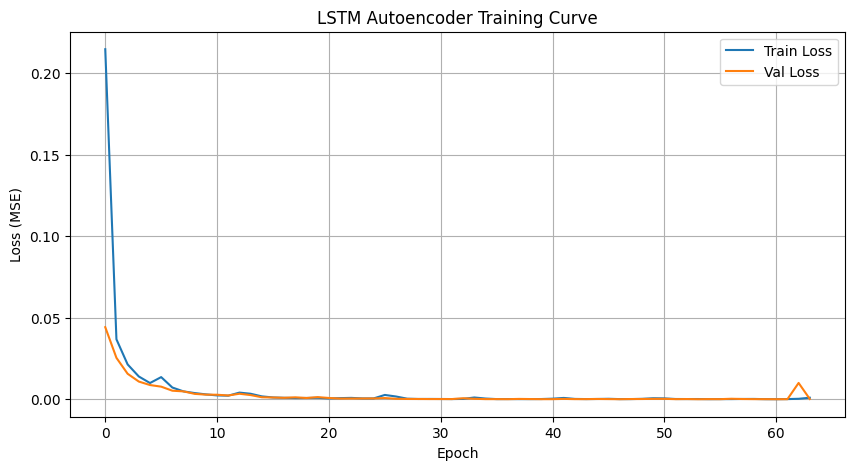

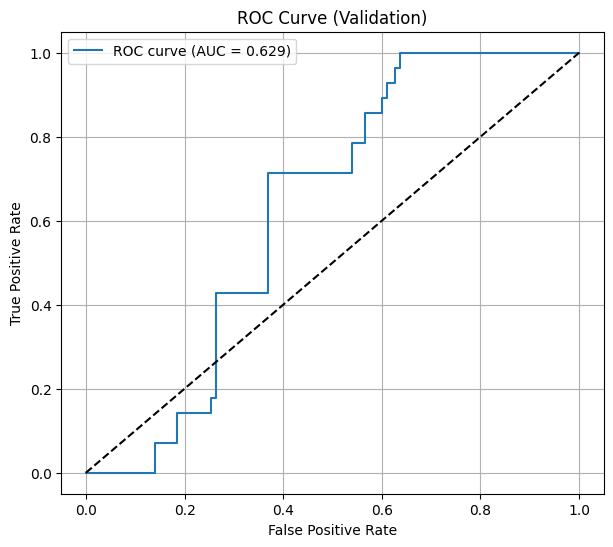

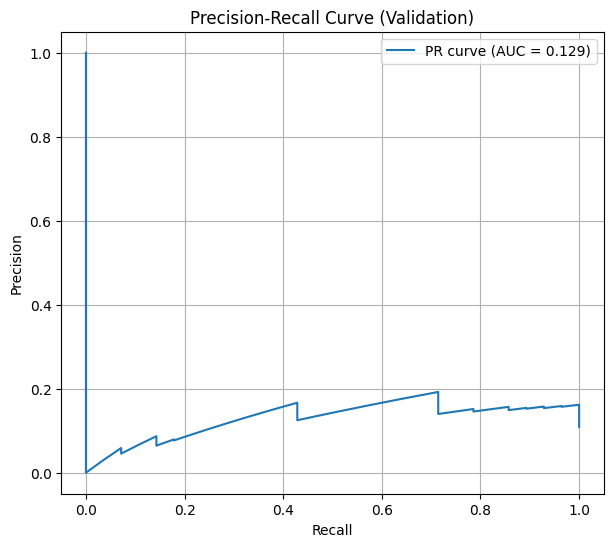

Matthews correlation coeff (MCC):
 0.2197931566007756


In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("LSTM Autoencoder Training Curve")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ROC
fpr, tpr, _ = roc_curve(y_val, mse_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Validation)")
plt.legend()
plt.grid(True)
plt.savefig('roc.pdf')
plt.show()

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_val, mse_val)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, label=f"PR curve (AUC = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Validation)")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import matthews_corrcoef
print("Matthews correlation coeff (MCC):\n", matthews_corrcoef(y_val, y_val_pred))